# Abstract

- **Datensatz**
  - Import von CSV-Daten (2022, 2023, 2024) und Filterung auf relevante Immobilienarten.
  - Aufteilung in Trainings- und Testdatensätze.

- **Preprocessing & Feature Engineering**
  - Aufbau von Pipelines zur Vorverarbeitung numerischer und kategorialer Merkmale.
  - Einsatz von Feature Engineering und optionaler Dimensionsreduktion.

- **Modellierung & Hyperparameter-Tuning**
  - Verwendung mehrerer Regressionsmodelle (ElasticNet, KNN, DecisionTree).
  - Optimierung der Modelle mittels RandomizedSearchCV - später auch GridSearchCV zum Finetuning, was jedoch verworfen ist und dem Testing dient.

- **Evaluation & Visualisierung**
  - Validierung der auf 2023/24 trainieretn Modelle über Kreuzvalidierung und 2022 Testdaten.
  - Darstellung der Ergebnisse durch Residuen-, Scatter-, Lernkurven- und SHAP-Visualisierungen.


# Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import shap

from scipy.stats import randint
from sklearn import set_config
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, RobustScaler, PowerTransformer, QuantileTransformer
from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV, train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score, median_absolute_error

# Modelle
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor

# Importiere Custom Transformer und andere ausgelagerte Funktionen
from scripts.models import (
    Winsorizer,
    LogTransformer,
    RareCategoryGrouper,
    FeatureEngineer,
    plot_parameter_interactions,
    plot_learning_curve_r2,
    residuen_plot,
    scatter_plot,
    get_top_records_per_model,
    plot_save_shap
)


# Config

In [2]:
# Reproduzierbarkeit
RANDOM_STATE = 42

# Input
PATH_CSV_SALES_2023 = os.path.join('input', 'data_property_sales_2023.csv')
PATH_CSV_SALES_2024 = os.path.join('input', 'data_property_sales_2024.csv')
PATH_CSV_SALES_2022 = os.path.join('input', 'data_property_sales_2022.csv')

# Output
PATH_RESULTS = os.path.join('output')

# UVs
NUM_FEATURES = [
    # Raw Features
    'Stories', 'Rooms', 'FinishedSqft', 'Units', 'Bdrms', 'Fbath', 'Hbath', 'Lotsize',
    # Feature Engineering
    'Building_age', 'StrNr'
]
CAT_FEATURES = [
    # Raw Features
    'PropType', 'District', 'Style', 'Extwall',
    # Feature Engineering
    'StrTyp', 'Sale_season', 'Sale_year'
]

# AV
TARGET_FEATURE = 'Sale_price'

# Filter
PROP_TYPES = ['Residential', 'Condominium']  # Siehe EDA aufgrund übermäiger Verzerrung der Daten durch eine sehr kleine Minderheit an PropType

# Random Search - Hyperparmetertuning
ITERATIONS_RANDOM_SEARCH = 2000 # Pro Modell, abhängig vom kartesische Produkt Hyperparameterverteilungen
CROSSFOLD  = 5  
COMPUTE    = -1  
SCORE = {
    'R2': 'r2',
    'MAE': 'neg_mean_absolute_error',
    'MedAE': 'neg_median_absolute_error'
}
SCORE_TARGET = 'MedAE'

# Grid Search - Finetuning: VERWORFEN, aber zur Testveranschaulichung abrufbar
Apply_GridSearchCV = False


In [3]:
set_config(display='diagram')
sns.set_theme()

# Data Collection

In [4]:
# Lese die CSV-Dateien ein
df_sales_2023 = pd.read_csv(PATH_CSV_SALES_2023)
df_sales_2024 = pd.read_csv(PATH_CSV_SALES_2024)
df_sales_2022 = pd.read_csv(PATH_CSV_SALES_2022) # Testdaten zweite Validation

# Kombiniere die beiden DataFrames
df_sales_2023_2024 = pd.concat([df_sales_2023, df_sales_2024], ignore_index=True)

# Filter PropType
df_sales_2023_2024 = df_sales_2023_2024[df_sales_2023_2024['PropType'].isin(PROP_TYPES)].copy()
df_sales_2022 = df_sales_2022[df_sales_2022['PropType'].isin(PROP_TYPES)].copy()

# Setze die Zielvariable (y) und die Features (X)
y = df_sales_2023_2024[TARGET_FEATURE]
X = df_sales_2023_2024.drop(TARGET_FEATURE, axis=1) 

y_2022 = df_sales_2022[TARGET_FEATURE]
X_2022 = df_sales_2022.drop(TARGET_FEATURE, axis=1)

# Pipeline
Mit Beispiel Parametern

In [5]:
# Numerische Pipeline: Zuerst Imputer, dann die Scaling-Subpipeline
scaling_pipeline = Pipeline([
    ('cutting', Winsorizer(lower_quantile='passthrough', upper_quantile='passthrough')),     # Schritt 2.1.1: Outlier-Cutting
    ('skewness', LogTransformer()),                                                          # Schritt 2.1.2: Transformation (alternativ: PowerTransformer, QuantileTransformer)
    ('scaler', RobustScaler())                                                               # Schritt 2.1.3: Skalierung
])

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='passthrough')), 
    ('scaling', scaling_pipeline)
])


# Kategoriale Pipeline
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='passthrough')), 
    ('to_str', FunctionTransformer(lambda X: X.astype(str))),
    ('rare_grouper', RareCategoryGrouper(threshold='passthrough', new_value='Other')),
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])


# Preprocessing-Pipeline
preprocessing_pipeline = Pipeline([
    ('feature_engineering', FeatureEngineer()),
    ('col_transform', ColumnTransformer([
          ('num', num_pipeline, NUM_FEATURES),
          ('cat', cat_pipeline, CAT_FEATURES)
    ])),
    ('pca', PCA(n_components=0.95))  # Schritt 2.2: PCA
])


# Modell Pipeline
model_pipeline = Pipeline([
    ('regressor', TransformedTargetRegressor(
                  regressor='passthrough',  # Modelle werden im Parameter Raum definiert
                  func=np.log1p,            # Log-Transformation des Targets
                  inverse_func=np.expm1     # Rücktransformation der Vorhersage
              ))
])


# Gesamt-Pipeline: Zwei Hauptschritte – Preprocessing und Modellierung
full_pipeline = Pipeline([
    ('preprocessing', preprocessing_pipeline),
    ('model', model_pipeline)
])

# visualize pipeline
print('Pipeline mit Beispiel-Schritten, welche später im Parameter-Raum variiert werden können:')
full_pipeline

Pipeline mit Beispiel-Schritten, welche später im Parameter-Raum variiert werden können:


Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('feature_engineering', FeatureEngineer()),
                                 ('col_transform',
                                  ColumnTransformer(transformers=[('num',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='passthrough')),
                                                                                   ('scaling',
                                                                                    Pipeline(steps=[('cutting',
                                                                                                     Winsorizer(lower_quantile='passthrough',
                                                                                                                upper_quantile='passthrough')),
                                                                                                    ('skewness',
                                                                                                     LogTransformer()...
                                                                                    RareCategoryGrouper(threshold='passthrough')),
                                                                                   ('onehot',
                                                                                    OneHotEncoder(drop='first',
                                                                                                  handle_unknown='ignore'))]),
                                                                   ['PropType',
                                                                    'District',
                                                                    'Style',
                                                                    'Extwall',
                                                                    'StrTyp',
                                                                    'Sale_season',
                                                                    'Sale_year'])])),
                                 ('pca', PCA(n_components=0.95))])),
                ('model',
                 Pipeline(steps=[('regressor',
                                  TransformedTargetRegressor(func=<ufunc 'log1p'>,
                                                             inverse_func=<ufunc 'expm1'>,
                                                             regressor='passthrough'))]))])

# Hyperparameteroptimierung

## 1 RandomizedSearchCV

### 1.1 Parameterraum

In [6]:
preprocessing_params = {
    # Numerisch
      # Imputation
    'preprocessing__col_transform__num__imputer__strategy': ['median', 'mean'],
      # Scaling: Cutting
    'preprocessing__col_transform__num__scaling__cutting__lower_quantile': np.linspace(0, 0.02, num=4),
    'preprocessing__col_transform__num__scaling__cutting__upper_quantile': np.linspace(0.98, 1, num=4),
      # Scaling: Skewness-Transformation
    'preprocessing__col_transform__num__scaling__skewness': [
        LogTransformer(columns=[i for i in range(len(NUM_FEATURES))]),
        'passthrough'
    ],
      # Scaling: Skalierung
    'preprocessing__col_transform__num__scaling__scaler': [
        RobustScaler(), QuantileTransformer(), PowerTransformer()
    ],

    # Kategorisch
      # Imputation
    'preprocessing__col_transform__cat__imputer__strategy': ['most_frequent', 'constant'],
      # Rare Category Grouper
    'preprocessing__col_transform__cat__rare_grouper__threshold': np.linspace(0.03, 0.05, num=4),
    # PCA
    'preprocessing__pca': ['passthrough', PCA(n_components=0.99, svd_solver='full')]
}


# ElasticNet-spezifische Parameter
elasticnet_params = {
    'model__regressor': [ElasticNet(random_state=RANDOM_STATE)],
    'model__regressor__alpha': np.linspace(0.01, 4, num=10),
    'model__regressor__l1_ratio': np.linspace(0.1, 0.8, num=10)
}

# KNeighborsRegressor-spezifische Parameter
knn_params = {
    'model__regressor': [KNeighborsRegressor()],
    'model__regressor__n_neighbors': np.linspace(5, 30, num=10).astype(int),
    'model__regressor__weights': ['uniform', 'distance'],
    'model__regressor__metric': ['euclidean', 'manhattan']
}

# DecisionTreeRegressor-spezifische Parameter
decision_tree_params = {
    'model__regressor': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
    'model__regressor__max_depth': randint(5, 20),
    'model__regressor__min_samples_split': randint(10, 50)
}


# Zusammenfassung der Hyperparameter
param_linear  = {**preprocessing_params, **elasticnet_params}
param_knn     = {**preprocessing_params, **knn_params}
param_tree    = {**preprocessing_params, **decision_tree_params}

# Modelle
param_rndm_models = {
    'ElasticNet': param_linear,
    'KNN': param_knn,
    'DecisionTree': param_tree
}

### 1.2 Anwendung

In [7]:
# Verwende einen stratifizierten Split basierend auf PropType
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=RANDOM_STATE, 
    stratify=X['PropType']
)

dict_result_rndm = {}
dict_best_params = {}

for model, param_grid in param_rndm_models.items():

    # Random Search
    random_search = RandomizedSearchCV(
        full_pipeline,
        param_distributions=param_grid,
        n_iter=ITERATIONS_RANDOM_SEARCH,
        cv=CROSSFOLD,
        scoring=SCORE,
        refit=SCORE_TARGET,
        n_jobs=COMPUTE,
        random_state=RANDOM_STATE,
        error_score=np.nan
    )

    random_search.fit(X_train, y_train)

    # Beste Parameter speichern
    dict_best_params[model] = random_search.best_params_

    # Speichern der Ergebnisse (hier sind beide Metriken, R² und MAE, pro Fold und als Durchschnitt enthalten)
    drop_cols_rs = ['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 
                    'split0_test_R2', 'split1_test_R2', 'split2_test_R2', 'split3_test_R2', 'split4_test_R2', 
                    'rank_test_R2', 'rank_test_MAE', 'params']
    
    dict_result_rndm[model] = pd.DataFrame(random_search.cv_results_).drop(columns=drop_cols_rs)

/usr/local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categ

## 2 Verworfen / Testing: GridSearch Finetuning

### 2.1 Exploration Parameterleistung






################### ElasticNet - Best Params ################### 
param_preprocessing__pca                                                                                           passthrough
param_preprocessing__col_transform__num__scaling__skewness                   LogTransformer(columns=[0, 1, 2, 3, 4, 5, 6, 7...
param_preprocessing__col_transform__num__scaling__scaler                                                        RobustScaler()
param_preprocessing__col_transform__num__scaling__cutting__upper_quantile                                             0.993333
param_preprocessing__col_transform__num__scaling__cutting__lower_quantile                                                  0.0
param_preprocessing__col_transform__num__imputer__strategy                                                              median
param_preprocessing__col_transform__cat__rare_grouper__threshold                                                      0.036667
param_preprocessing__col_transform__cat_

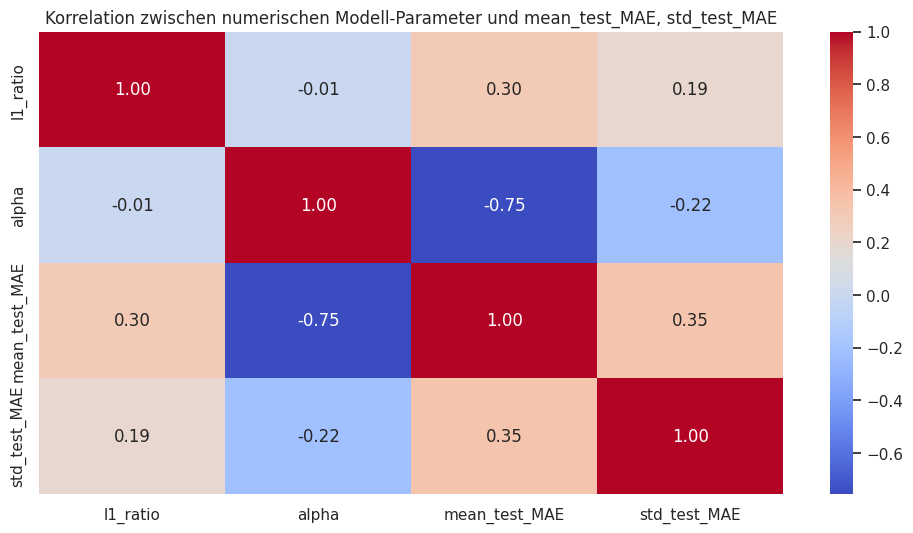

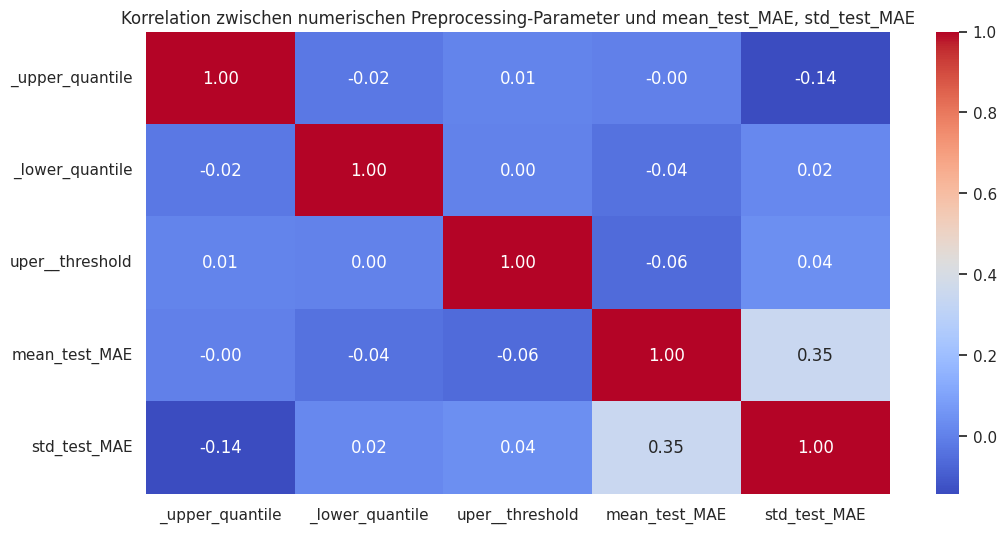

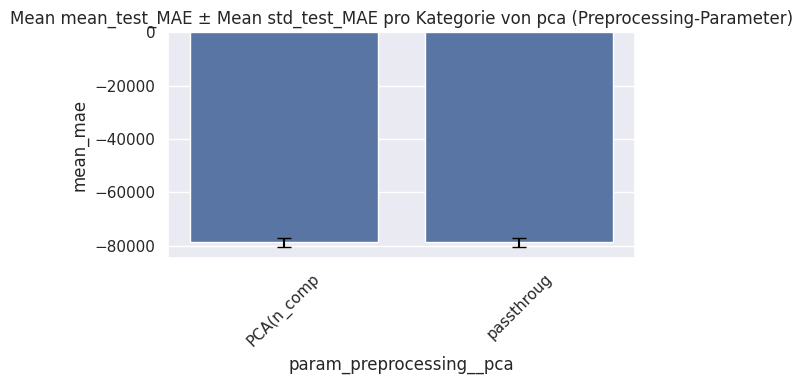

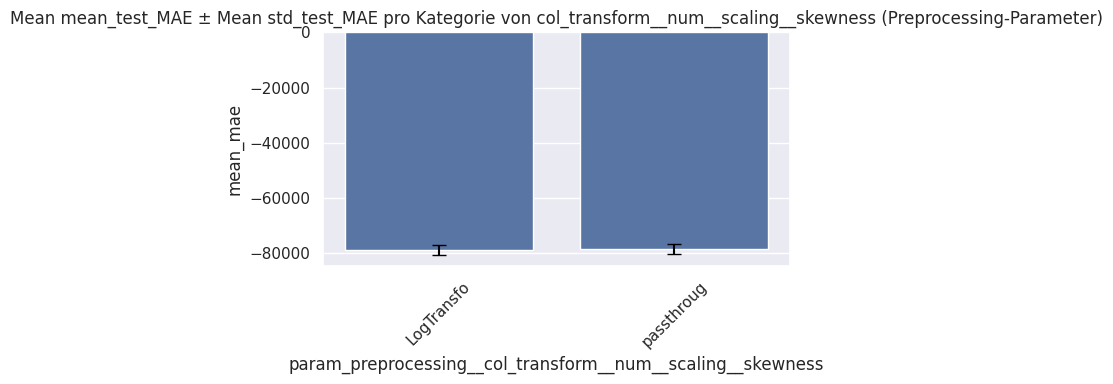

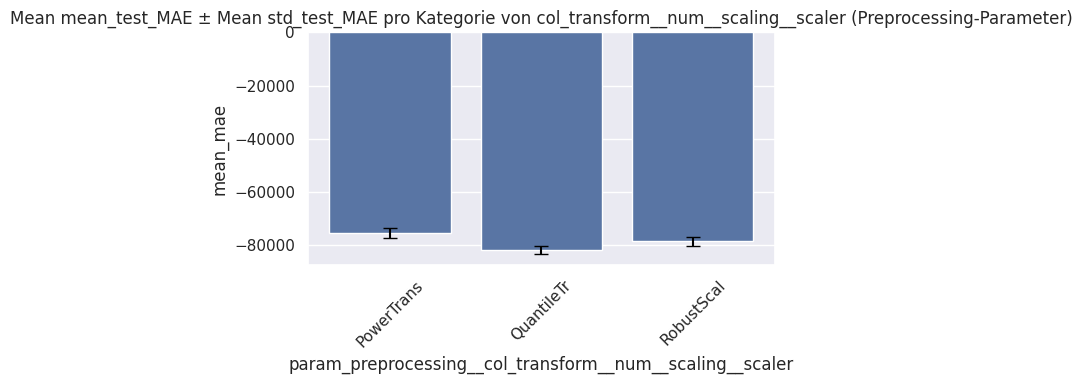

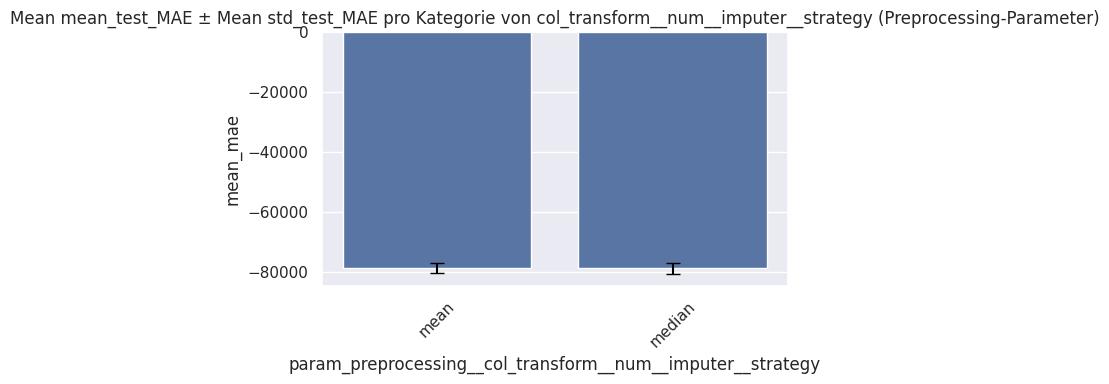

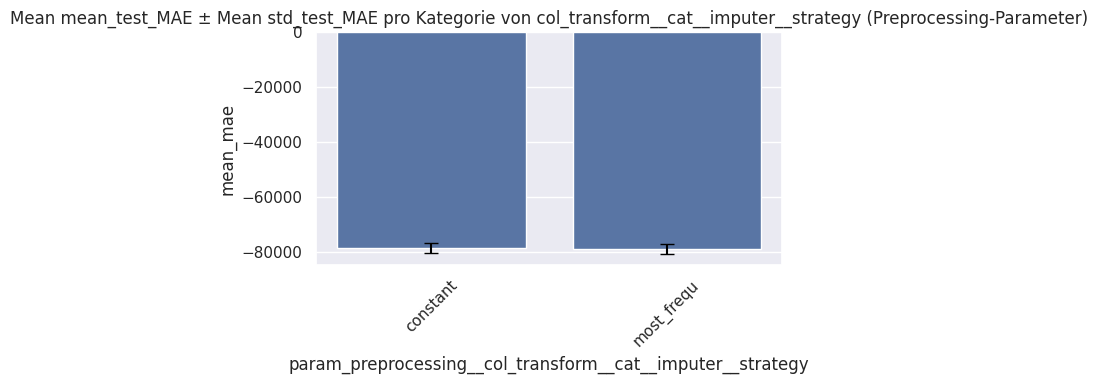






################### KNN - Best Params ################### 
param_preprocessing__pca                                                             PCA(n_components=0.99, svd_solver='full')
param_preprocessing__col_transform__num__scaling__skewness                   LogTransformer(columns=[0, 1, 2, 3, 4, 5, 6, 7...
param_preprocessing__col_transform__num__scaling__scaler                                                    PowerTransformer()
param_preprocessing__col_transform__num__scaling__cutting__upper_quantile                                             0.993333
param_preprocessing__col_transform__num__scaling__cutting__lower_quantile                                                  0.0
param_preprocessing__col_transform__num__imputer__strategy                                                                mean
param_preprocessing__col_transform__cat__rare_grouper__threshold                                                          0.05
param_preprocessing__col_transform__cat__impute

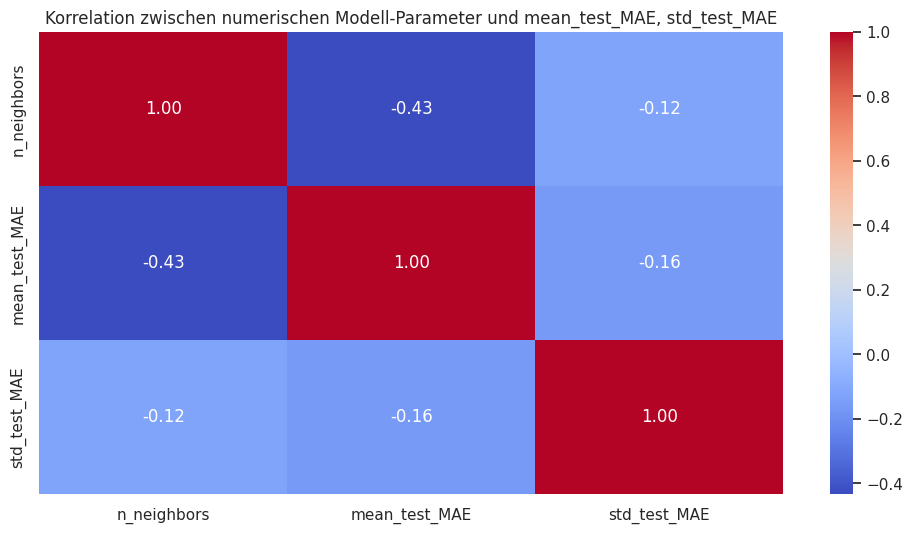

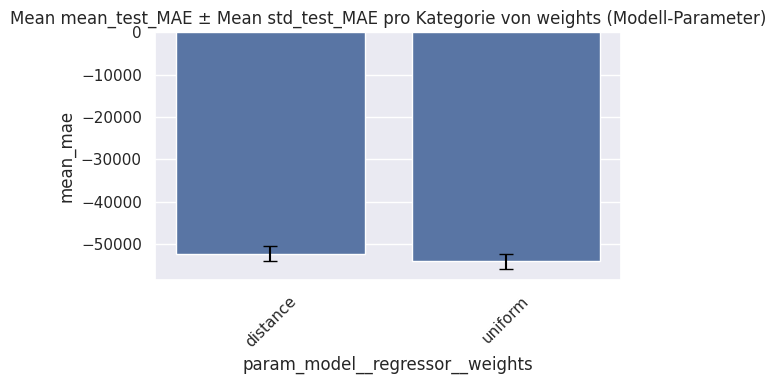

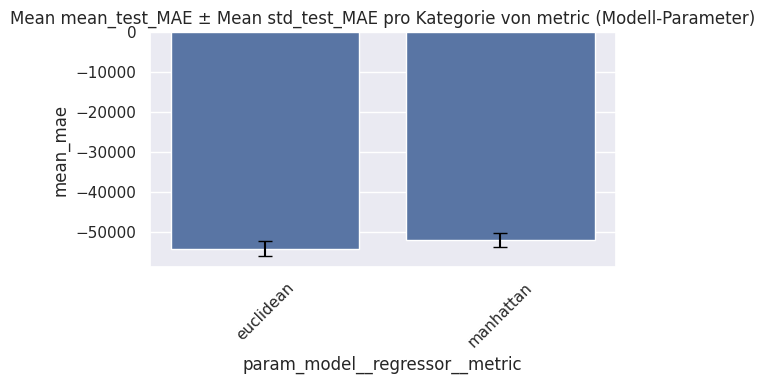

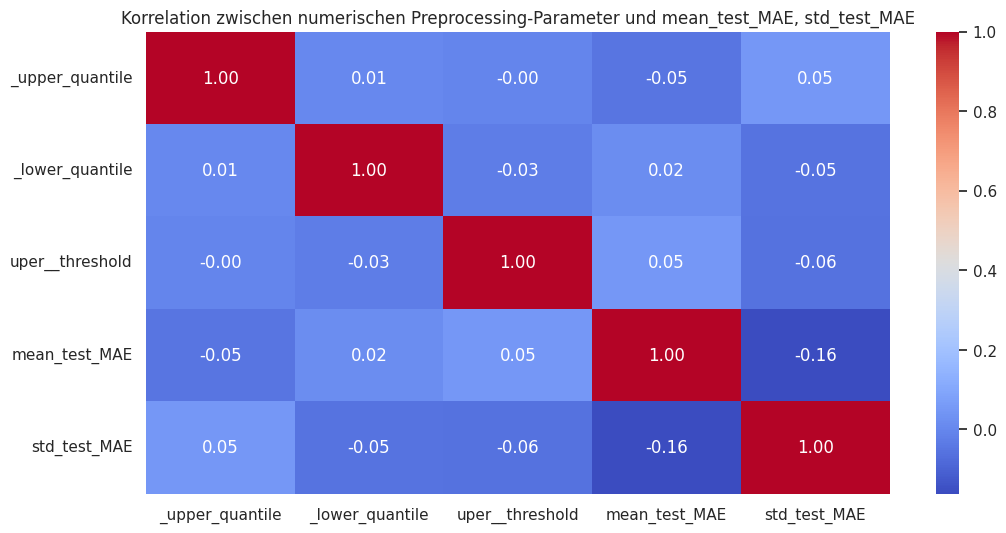

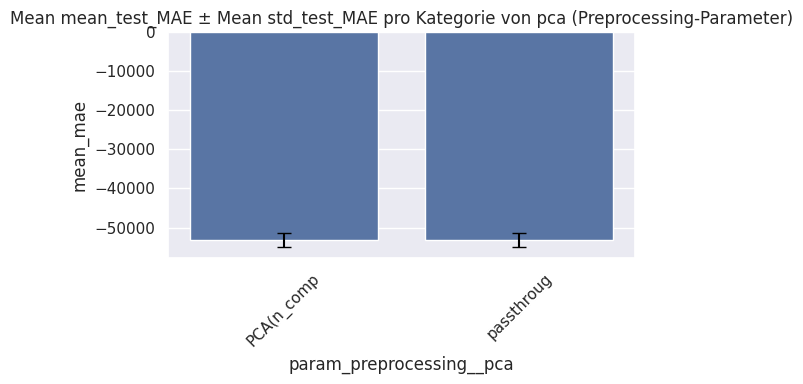

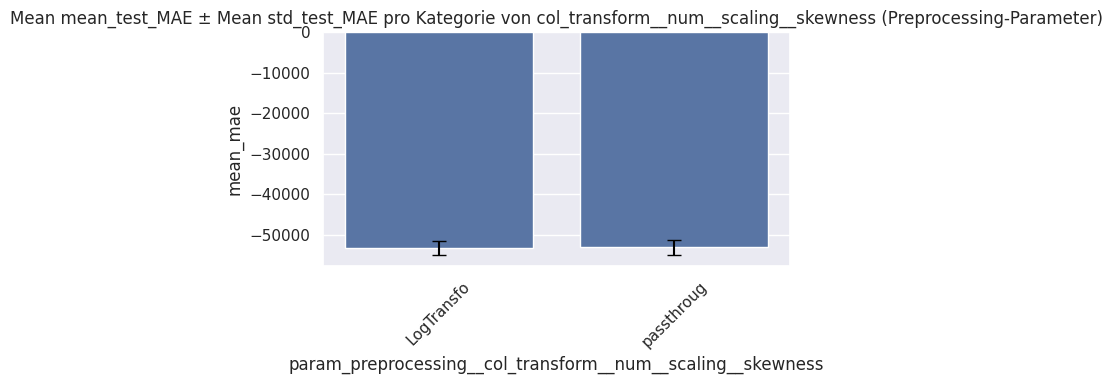

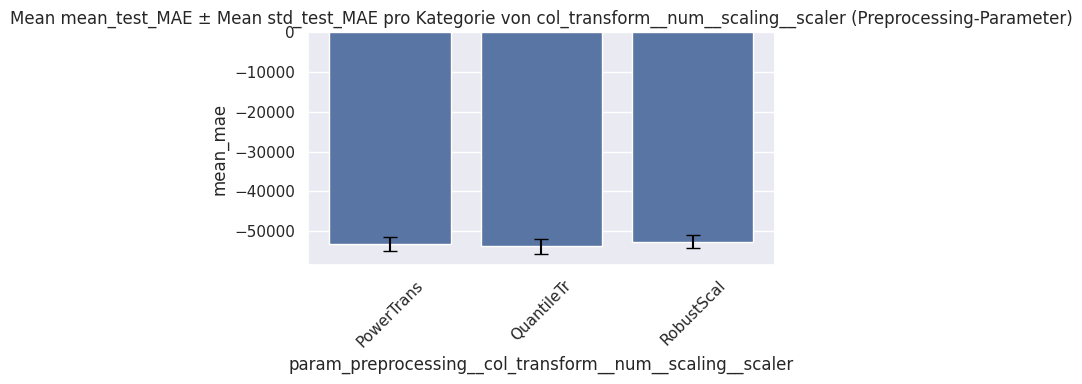

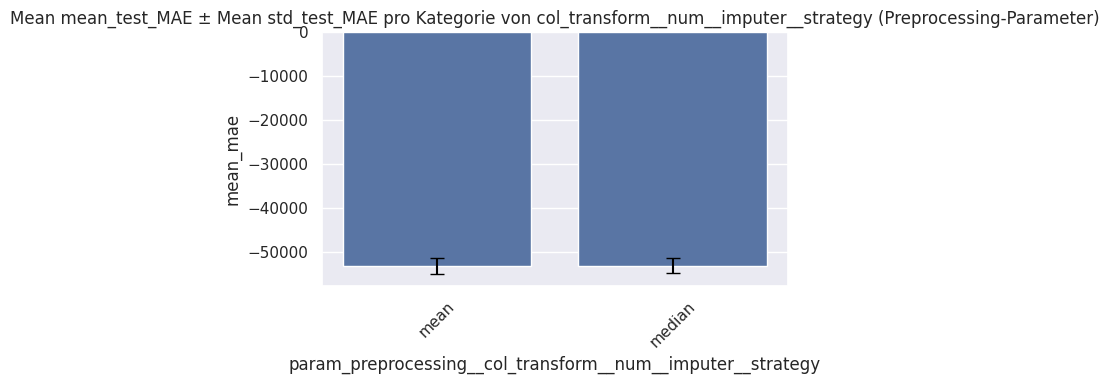

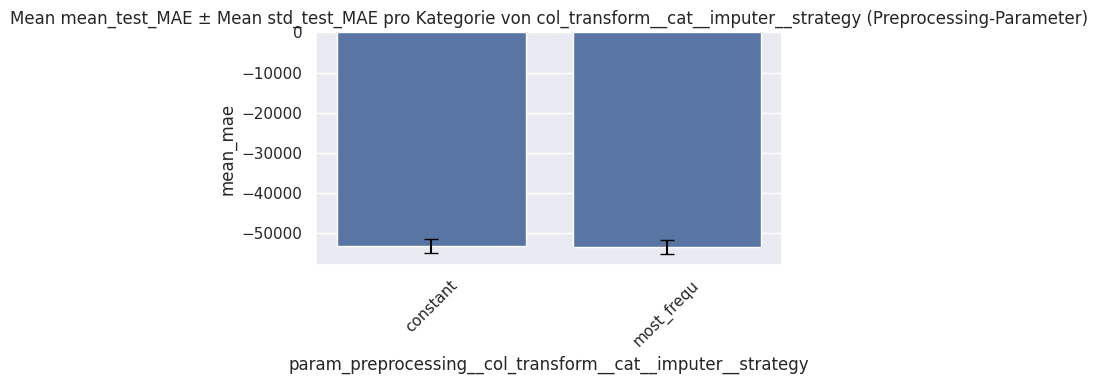






################### DecisionTree - Best Params ################### 
param_model__regressor                                                       DecisionTreeRegressor(random_state=42)
param_model__regressor__max_depth                                                                                16
param_model__regressor__min_samples_split                                                                        13
param_preprocessing__col_transform__cat__imputer__strategy                                                 constant
param_preprocessing__col_transform__cat__rare_grouper__threshold                                               0.03
param_preprocessing__col_transform__num__imputer__strategy                                                     mean
param_preprocessing__col_transform__num__scaling__cutting__lower_quantile                                      0.02
param_preprocessing__col_transform__num__scaling__cutting__upper_quantile                                  0.986667

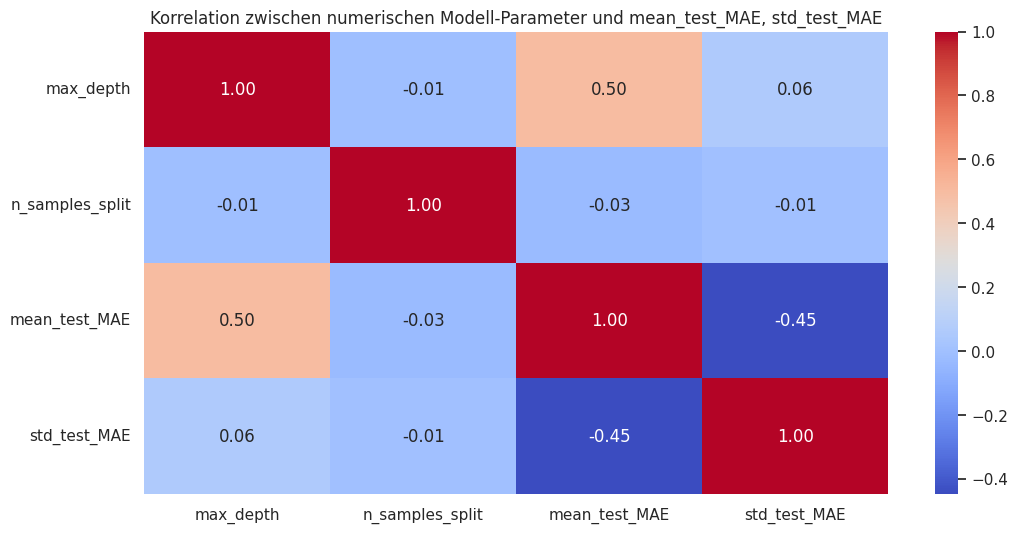

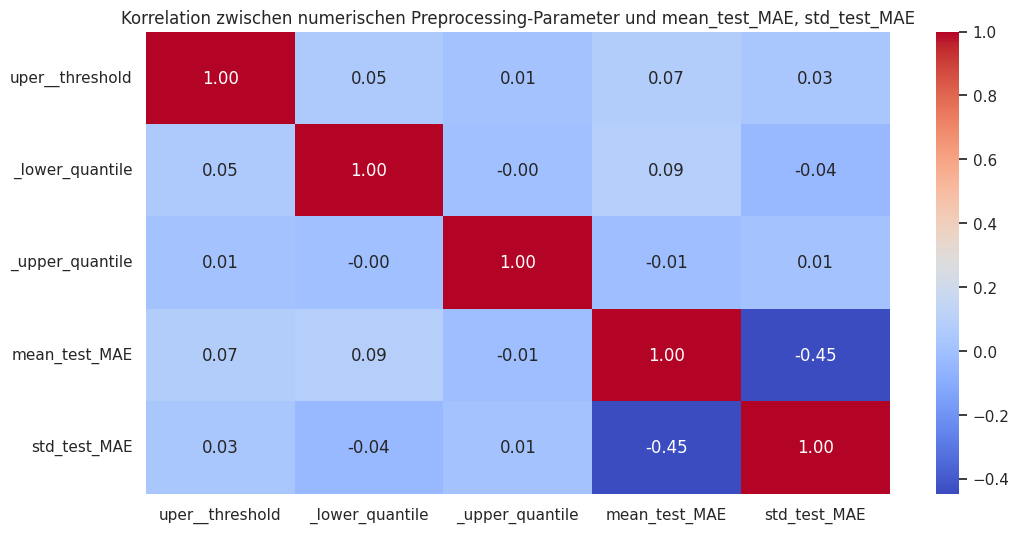

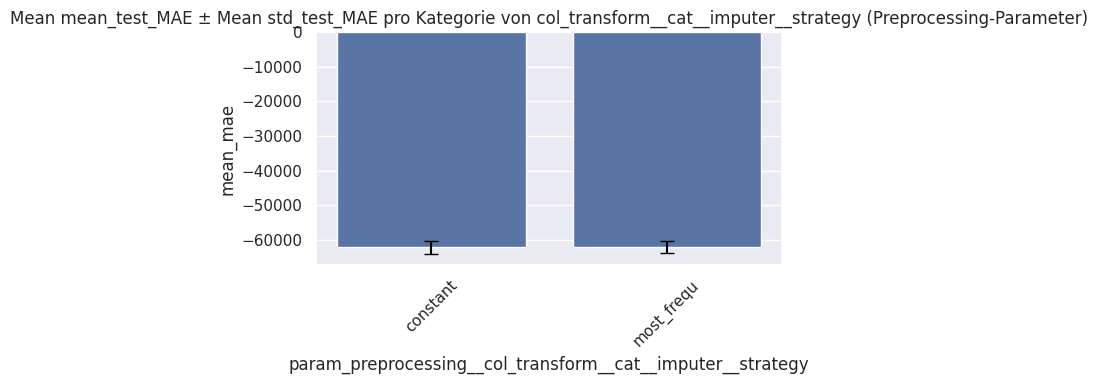

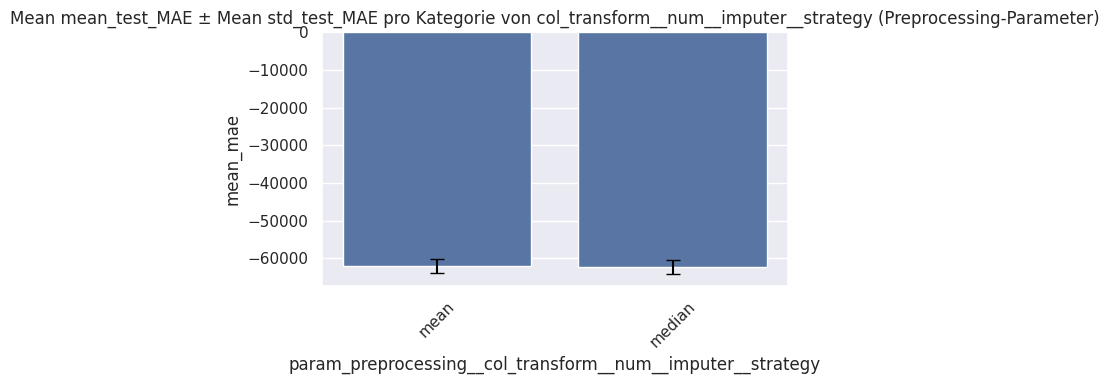

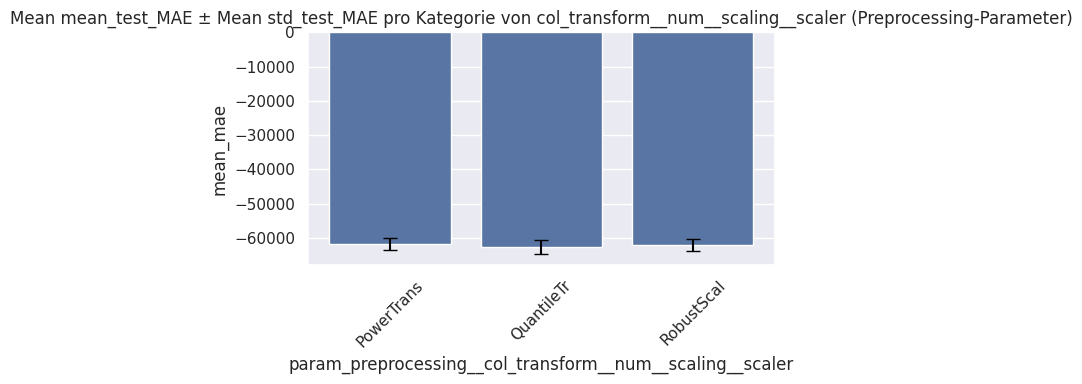

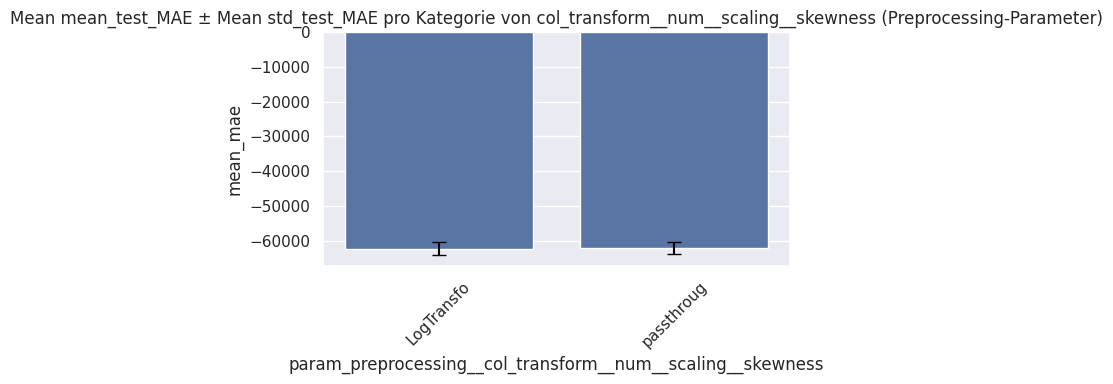

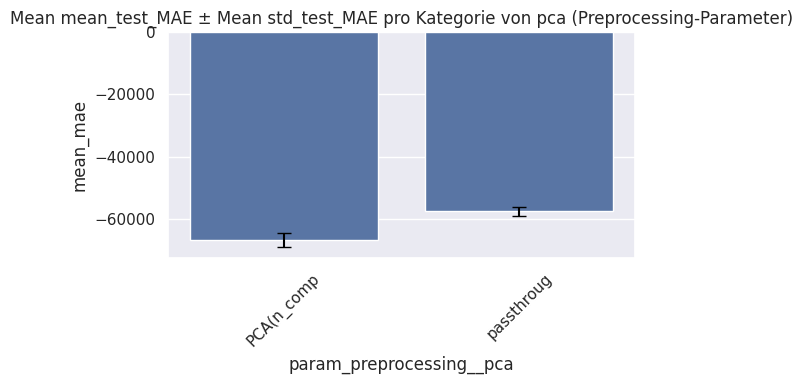

In [8]:
for model, df_model in dict_result_rndm.items():
    best_mae_record = df_model.loc[df_model['mean_test_MAE'].idxmax()]
    print(f"""\n\n\n\n\n################### {model} - Best Params ################### \n{best_mae_record}\n\n""")
    plot_parameter_interactions(df_model, col_mae = 'mean_test_MAE', col_mae_std = 'std_test_MAE', view = "model")
    plot_parameter_interactions(df_model, col_mae = 'mean_test_MAE', col_mae_std = 'std_test_MAE', view = "preprocessing")

#### 2.1.1 Fazit (früherer Durchläufe)

| Model          | Parameter/Preprocessing                     | MAE-Wert                      | Std_MAE-Wert                 | Kommentar                              |
|---------------|-------------------------------------------|------------------------------|------------------------------|----------------------------------------|
| **Elastic Net** | alpha                                  | -0.54                        | 0.20                          | verringern (!) Overfitting                                      |
|               | l1_ratio                                | 0.58                        | 0.30                          | erhöhren                                     |
|               | Cutting upper quantile (0.2)           |  --                      | -0.28                          |  ggf. verringern                                    |
|               | Cat_Rare_Grouper_Threshold           |  -0.12                      | -0.28                          |  ggf. verringern                                    |
|               | Scaling               | PowerTr < RobustSc               |                              | PowerTransformer am besten           |
|               | PCA                              |     keine < PCA                    |                              | Keine PCA besser                      |
| **KNN**       | Neighbors                              | -0.14                        | -0.06                         | ggf. verkleinern (!) Overfitting                                    |
|               | Manhattan Distance                     | > Euclidean                  |                              | Manhattan am besten                   |
|               | Distance                              | < Uniform                    |                              |                                      |
|               | Kaum Interaktionen                    | <~0.05 bzgl. Korrelation     |                              |                                      |
|               | Keine PCA                              | > PCA                        |                              | Keine PCA besser                      |
| **Decision Tree** | Model-Parameter                     | ~ < 0.05 bzgl. Korrelation   |                              |ggf. Tiefe erhöhen (!) Overfitting         |
|               | Cat_Rare_Grouper_Threshold            |                          | 0.29                     |  ggf. erhöhen                                    |
|               | Scaling                      | Power Transformer    |                              | PowerTransformer am besten           |
|               | Keine PCA                              | besser als PCA               |                              | Keine PCA besser                      |


### 2.2 Parameterraum - Angepasst

In [9]:
for model, df_model in dict_result_rndm.items():
    print(f"""\n\n\n\n\n################### {model} - Best Params ###################\n""")
    display(df_model.loc[df_model['mean_test_MAE'].idxmax()].filter(like="param_"))






################### ElasticNet - Best Params ###################



param_preprocessing__pca                                                                                           passthrough
param_preprocessing__col_transform__num__scaling__skewness                   LogTransformer(columns=[0, 1, 2, 3, 4, 5, 6, 7...
param_preprocessing__col_transform__num__scaling__scaler                                                        RobustScaler()
param_preprocessing__col_transform__num__scaling__cutting__upper_quantile                                             0.993333
param_preprocessing__col_transform__num__scaling__cutting__lower_quantile                                                  0.0
param_preprocessing__col_transform__num__imputer__strategy                                                              median
param_preprocessing__col_transform__cat__rare_grouper__threshold                                                      0.036667
param_preprocessing__col_transform__cat__imputer__strategy                                                     






################### KNN - Best Params ###################



param_preprocessing__pca                                                             PCA(n_components=0.99, svd_solver='full')
param_preprocessing__col_transform__num__scaling__skewness                   LogTransformer(columns=[0, 1, 2, 3, 4, 5, 6, 7...
param_preprocessing__col_transform__num__scaling__scaler                                                    PowerTransformer()
param_preprocessing__col_transform__num__scaling__cutting__upper_quantile                                             0.993333
param_preprocessing__col_transform__num__scaling__cutting__lower_quantile                                                  0.0
param_preprocessing__col_transform__num__imputer__strategy                                                                mean
param_preprocessing__col_transform__cat__rare_grouper__threshold                                                          0.05
param_preprocessing__col_transform__cat__imputer__strategy                                                     






################### DecisionTree - Best Params ###################



param_model__regressor                                                       DecisionTreeRegressor(random_state=42)
param_model__regressor__max_depth                                                                                16
param_model__regressor__min_samples_split                                                                        13
param_preprocessing__col_transform__cat__imputer__strategy                                                 constant
param_preprocessing__col_transform__cat__rare_grouper__threshold                                               0.03
param_preprocessing__col_transform__num__imputer__strategy                                                     mean
param_preprocessing__col_transform__num__scaling__cutting__lower_quantile                                      0.02
param_preprocessing__col_transform__num__scaling__cutting__upper_quantile                                  0.986667
param_preprocessing__col_transform__num__scaling__scaler                

In [10]:
param_linear = {
    'preprocessing__col_transform__num__imputer__strategy': ['mean'],
    'preprocessing__col_transform__num__scaling__cutting__lower_quantile': [0, 0.01],
    'preprocessing__col_transform__num__scaling__cutting__upper_quantile': [0.995, 1],
    'preprocessing__col_transform__num__scaling__skewness': ['passthrough'],
    'preprocessing__col_transform__num__scaling__scaler': [PowerTransformer()],
    'preprocessing__col_transform__cat__imputer__strategy': ['most_frequent'],
    'preprocessing__col_transform__cat__rare_grouper__threshold': [0.04, 0.03],
    'preprocessing__pca': ['passthrough'], 
    'model__regressor': [ElasticNet(random_state=RANDOM_STATE)],
    'model__regressor__alpha': [0.2, 0.25, 0.3, 0.35, 0.4], #Gefahr Overfitting wegen weniger Regularisierung
    'model__regressor__l1_ratio': [0.98, 0.99, 1] # Höher L1-Ratio, mehr Lasso-Regulierung / Feature Selektion
}

param_knn = {
    'preprocessing__col_transform__num__imputer__strategy': ['median'],
    'preprocessing__col_transform__num__scaling__cutting__lower_quantile': [0, 0.01],
    'preprocessing__col_transform__num__scaling__cutting__upper_quantile': [0.99, 0.995],
    'preprocessing__col_transform__num__scaling__skewness': [LogTransformer(columns=[i for i in range(len(NUM_FEATURES))])],
    'preprocessing__col_transform__num__scaling__scaler': [RobustScaler(), QuantileTransformer()],
    'preprocessing__col_transform__cat__imputer__strategy': ['constant'],
    'preprocessing__col_transform__cat__rare_grouper__threshold': [0.05],
    'preprocessing__pca': ['passthrough'], 
    'model__regressor': [KNeighborsRegressor()],
    'model__regressor__n_neighbors': [7, 8, 9, 10, 12, 15],
    'model__regressor__weights': ['distance'],
    'model__regressor__metric': ['manhattan']
}

param_tree = {
    'preprocessing__col_transform__num__imputer__strategy': ['median', 'mean'],
    'preprocessing__col_transform__num__scaling__cutting__lower_quantile': [0.01],
    'preprocessing__col_transform__num__scaling__cutting__upper_quantile': [0.98],
    'preprocessing__col_transform__num__scaling__skewness': ['passthrough'],
    'preprocessing__col_transform__num__scaling__scaler': [PowerTransformer()],
    'preprocessing__col_transform__cat__imputer__strategy': ['constant'],
    'preprocessing__col_transform__cat__rare_grouper__threshold': [0.07, 0.05],
    'preprocessing__pca': ['passthrough'], 
    'model__regressor': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
    'model__regressor__max_depth': [15, 16, 17, 18, 20],
    'model__regressor__min_samples_split': [12, 13, 14, 15]
}

param_grid_models = {
    'ElasticNet': param_linear,
    'KNN': param_knn,
    'DecisionTree': param_tree
}

for model, param_grid in param_grid_models.items():
    # Anzahl der Parameter zählen
    param_counts = [len(values) for values in param_grid.values()]
    total_iterations = np.prod(param_counts)
    print(f"Anzahl der erforderlichen Grid-Search-Iterationen für {model}: {total_iterations}")


Anzahl der erforderlichen Grid-Search-Iterationen für ElasticNet: 120
Anzahl der erforderlichen Grid-Search-Iterationen für KNN: 48
Anzahl der erforderlichen Grid-Search-Iterationen für DecisionTree: 80


### 2.3 GridSearch

In [11]:
# Apply GridSearchCV

if Apply_GridSearchCV:
    # Verwende einen stratifizierten Split basierend auf PropType
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=0.2, 
        random_state=RANDOM_STATE, 
        stratify=X['PropType']
    )

    dict_result_grid = {}

    for model, param_grid in param_grid_models.items():

        # Grid Search
        grid_search = GridSearchCV(
            estimator=full_pipeline,
            param_grid=param_grid,
            cv=CROSSFOLD,
            scoring=SCORE,
            refit=SCORE_TARGET,
            n_jobs=COMPUTE,
            error_score=np.nan
        )

        random_search.fit(X_train, y_train)

        # Speichern der Ergebnisse (hier sind beide Metriken, R² und MAE, pro Fold und als Durchschnitt enthalten)
        drop_cols_rs = ['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 
                        'split0_test_R2', 'split1_test_R2', 'split2_test_R2', 'split3_test_R2', 'split4_test_R2', 
                        'rank_test_R2', 'rank_test_MAE', 'params']
        
        dict_result_grid[model] = pd.DataFrame(random_search.cv_results_).drop(columns=drop_cols_rs)
        dict_result_grid[model].to_csv(f"output/param_grid_{model}.csv", index=False)

In [12]:
if Apply_GridSearchCV:
    for model, df_model in dict_result_grid.items():
        best_mae_record = df_model.loc[df_model['mean_test_MAE'].idxmax()]
        print(f"""\n\n\n\n\n################### {model} - Best Params ################### \n{best_mae_record}\n\n""")
        plot_parameter_interactions(df_model, col_mae = 'mean_test_MAE', col_mae_std = 'std_test_MAE', view = "model")
        plot_parameter_interactions(df_model, col_mae = 'mean_test_MAE', col_mae_std = 'std_test_MAE', view = "preprocessing")

# Darstellung der Ergebnisse

## 1 Kreuzvalidierung

Relativ wenig Streuung, was für Generalisierbarkeit spricht

In [13]:
# Kreuzvalidierung basierend auf eigener script smethode get_top_records_per_model via dict_result_rndm
top_model_results = get_top_records_per_model(dict_result_rndm, top_n_per_model=1, kpi='MedAE')
top_model_results.to_csv(os.path.join(PATH_RESULTS, 'top_model_results.csv'), index=False)
top_model_results


,Regressor,R2_mean_%,R2_std_%,MAE_mean,MAE_std,MedAE_mean,MedAE_std
0,ElasticNet,58,4,60527,2151,43232,1509
1,KNN,71,4,49448,1119,34029,921
2,DecisionTree,61,4,54203,1200,35563,899


### 1.1 Seperater Test -> 2022
Modell erklät vergleichebare Varianz zu den auf 2023 und 2024 trainierten Daten

In [14]:
# Wende beste Modelle auf die Testdaten an

results = []
for model, best_params in dict_best_params.items():
    full_pipeline.set_params(**best_params)
    full_pipeline.fit(X_train, y_train)
    y_pred = full_pipeline.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    medae = median_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.append([model, mae, medae, r2])

print("\n\n\n\n\n################### Testdaten - Ergebnisse ###################")
top_model_results_2022 =  pd.DataFrame(results, columns=['Model', 'MAE', 'MedAE', 'R2'])
top_model_results_2022.to_csv(os.path.join(PATH_RESULTS, 'top_model_results_2022.csv'), index=False)
top_model_results_2022

/usr/local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(







################### Testdaten - Ergebnisse ###################


/usr/local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


,Model,MAE,MedAE,R2
0,ElasticNet,58131.197555,42415.252164,0.541027
1,KNN,48114.934455,33026.833072,0.723332
2,DecisionTree,52074.440207,33762.745098,0.608992


## 2 Residuenplot

/usr/local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


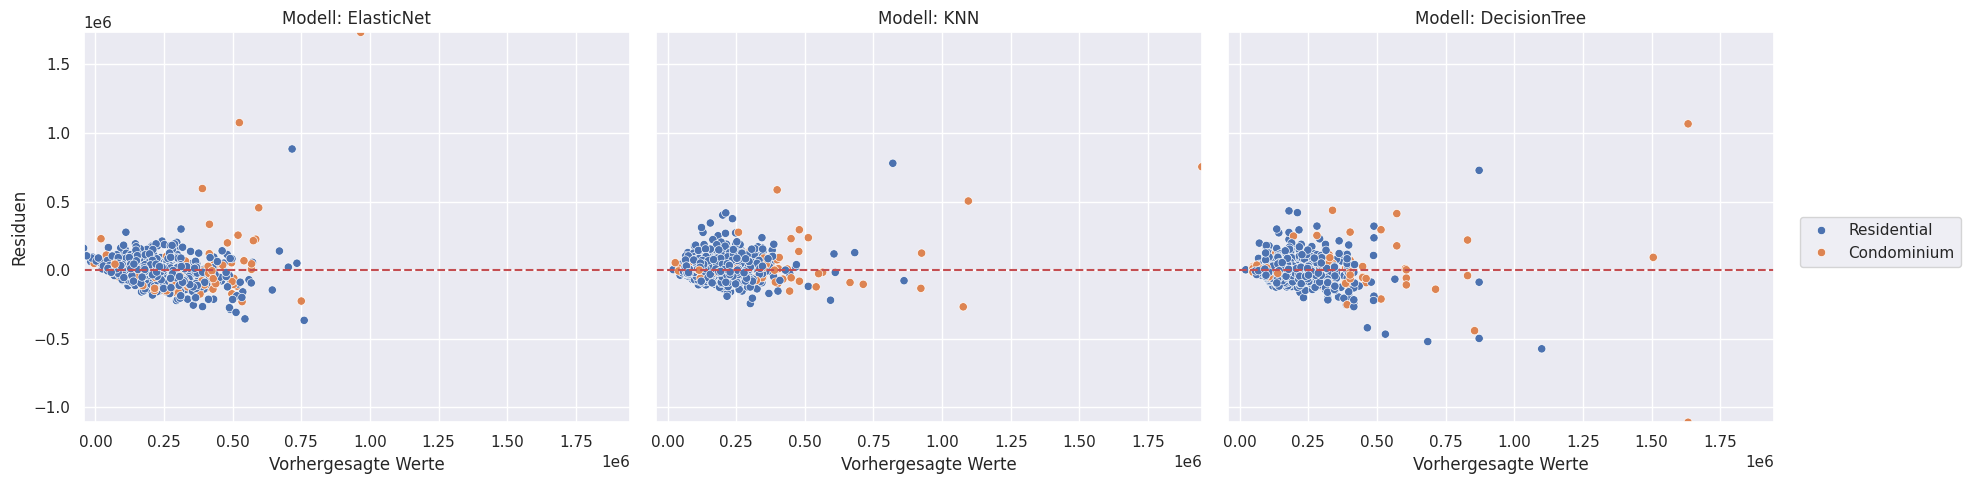

In [15]:
residuen_plot(
    dict_best_params, 
    X_train, 
    y_train, 
    X_test, 
    y_test, 
    full_pipeline, 
    kategorien=X_test['PropType'],
    save_path=os.path.join(PATH_RESULTS, 'residuen_plot.png')
)

## 3 Scatterplot Wahr<->Schätzung

/usr/local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


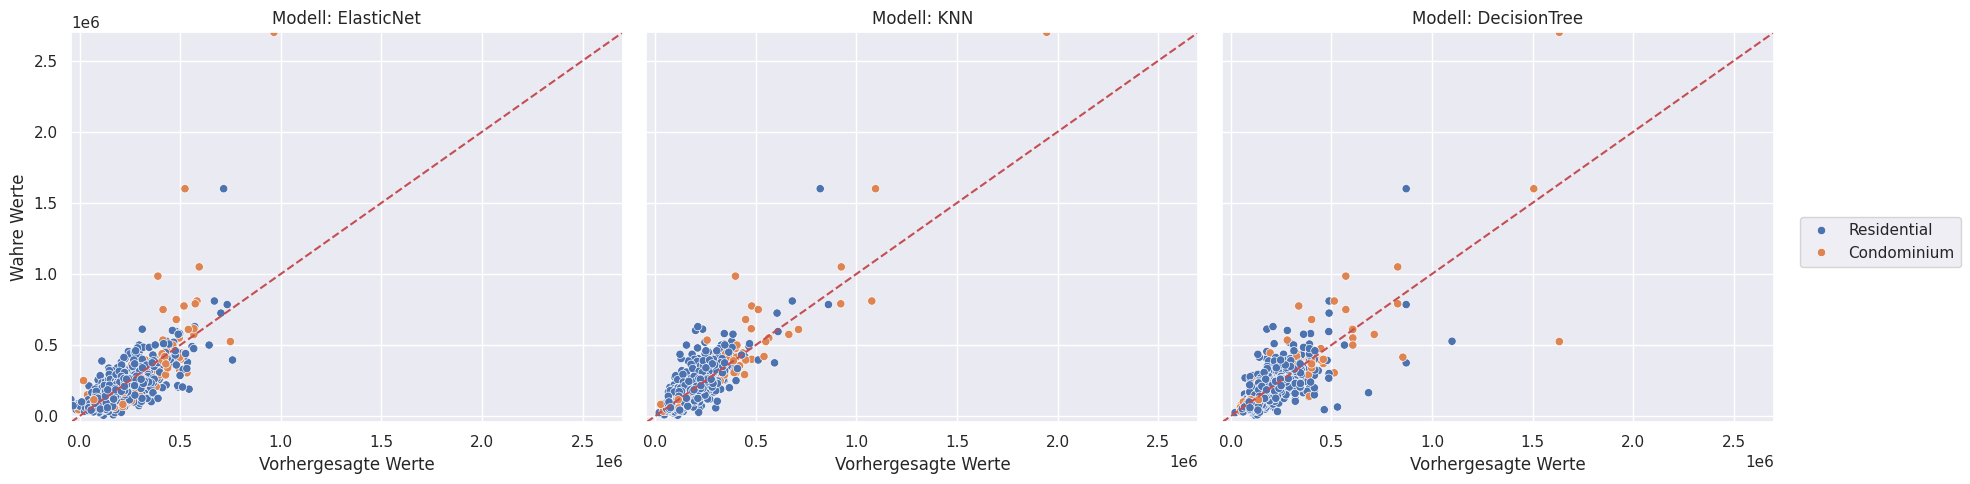

In [16]:
scatter_plot(
    dict_best_params,
    X_train, 
    y_train, 
    X_test, 
    y_test, 
    full_pipeline, 
    kategorien=X_test['PropType'],
    save_path=os.path.join(PATH_RESULTS, 'scatter_plot.png')
)

## 4 Lernkurve

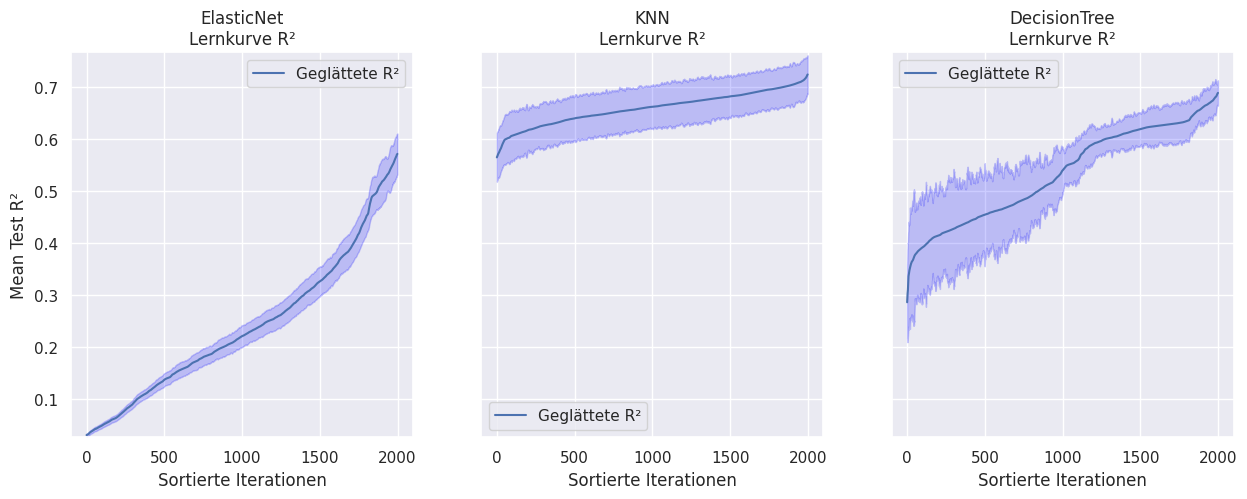

In [ ]:


plot_learning_curve_r2(
    dict_result_rndm = dict_result_rndm,
    save_path=os.path.join(PATH_RESULTS, 'learning_curve.png')
)        

Linie: Der geglättete Mittelwert (Mean Test R²) über die Iterationen.\
Rand: Der Fehlerbereich (z. B. ± Standardabweichung) um diesen Mittelwert, der die Variabilität der Werte anzeigt.

## 5 SHAP Feature Importance

  0%|          | 0/1360 [00:00<?, ?it/s]

/usr/local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


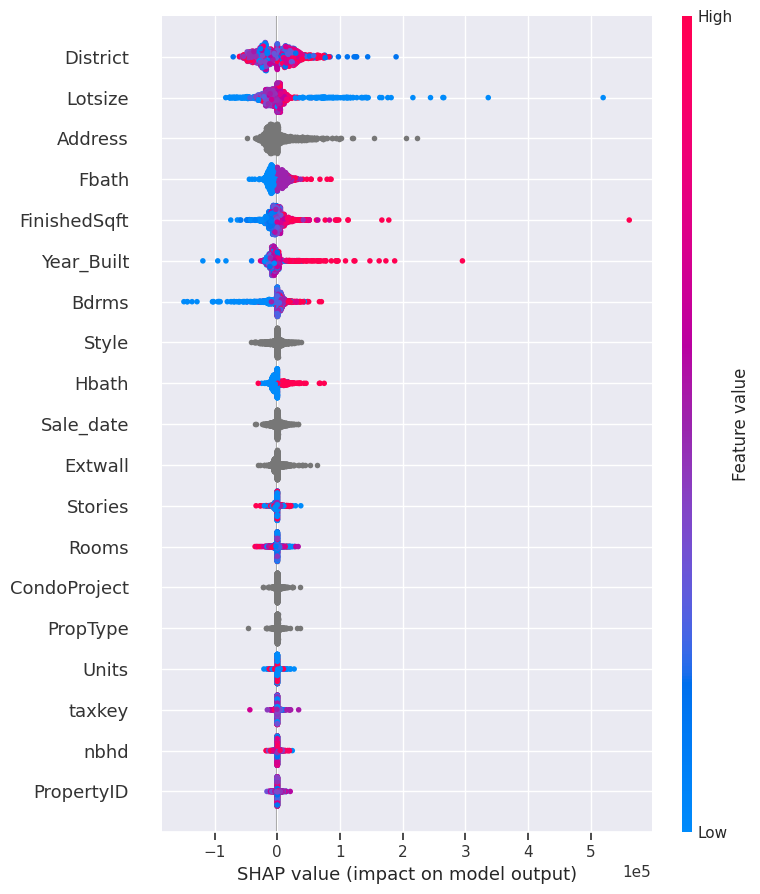

In [18]:
best_model_params = dict_best_params["KNN"]
plot_save_shap(best_model_params, X_train, y_train, X_test, full_pipeline, 
                os.path.join(PATH_RESULTS, 'shap_plot.png'))